[TIMER INFO] Using device: cuda
[TIMER INFO] Loading preprocessed dataset...
[TIMER INFO] Preprocessed dataset loaded

Testing CNNLSTM model:
[TIMER INFO] Data preparation completed
[TIMER INFO] Starting training for CNNLSTM Model...
[EPOCH 1/200] Train Loss: 2.0185, Val Loss: 1.5206, Val Acc: 0.4576 - Time: 13.12s
[EPOCH 2/200] Train Loss: 1.4350, Val Loss: 1.3102, Val Acc: 0.5589 - Time: 12.90s
[EPOCH 3/200] Train Loss: 1.2584, Val Loss: 1.2190, Val Acc: 0.5907 - Time: 13.07s
[EPOCH 4/200] Train Loss: 1.1529, Val Loss: 1.1905, Val Acc: 0.6130 - Time: 12.86s
[EPOCH 5/200] Train Loss: 1.0867, Val Loss: 1.1541, Val Acc: 0.6265 - Time: 12.93s
[EPOCH 6/200] Train Loss: 1.0348, Val Loss: 1.1431, Val Acc: 0.6294 - Time: 12.80s
[EPOCH 7/200] Train Loss: 0.9874, Val Loss: 1.1225, Val Acc: 0.6464 - Time: 12.79s
[EPOCH 8/200] Train Loss: 0.9370, Val Loss: 1.0963, Val Acc: 0.6512 - Time: 13.09s
[EPOCH 9/200] Train Loss: 0.8930, Val Loss: 1.1087, Val Acc: 0.6589 - Time: 12.81s
[EPOCH 10/200] Trai

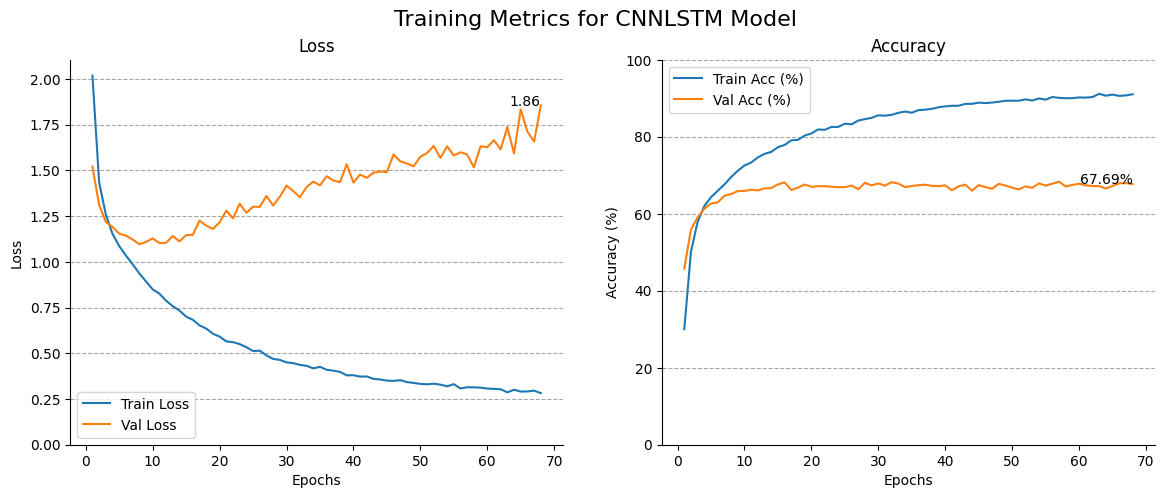


=== Evaluation Results ===
Accuracy: 0.6769, Precision: 0.6948, Recall: 0.6769, F1 Score: 0.6808
              precision    recall  f1-score   support

           0       0.44      0.53      0.48       151
           1       0.57      0.68      0.62       202
           2       0.66      0.55      0.60       195
           3       0.51      0.67      0.58       183
           4       0.78      0.59      0.67       205
           5       0.77      0.79      0.78       215
           6       0.82      0.67      0.74       193
           7       0.50      0.69      0.58       196
           8       0.73      0.70      0.71       168
           9       0.82      0.84      0.83       211
          10       0.95      0.80      0.87       198
          11       0.82      0.69      0.75       201
          12       0.69      0.56      0.62       202
          13       0.83      0.84      0.83       194
          14       0.66      0.80      0.72       189
          15       0.77      0.68    

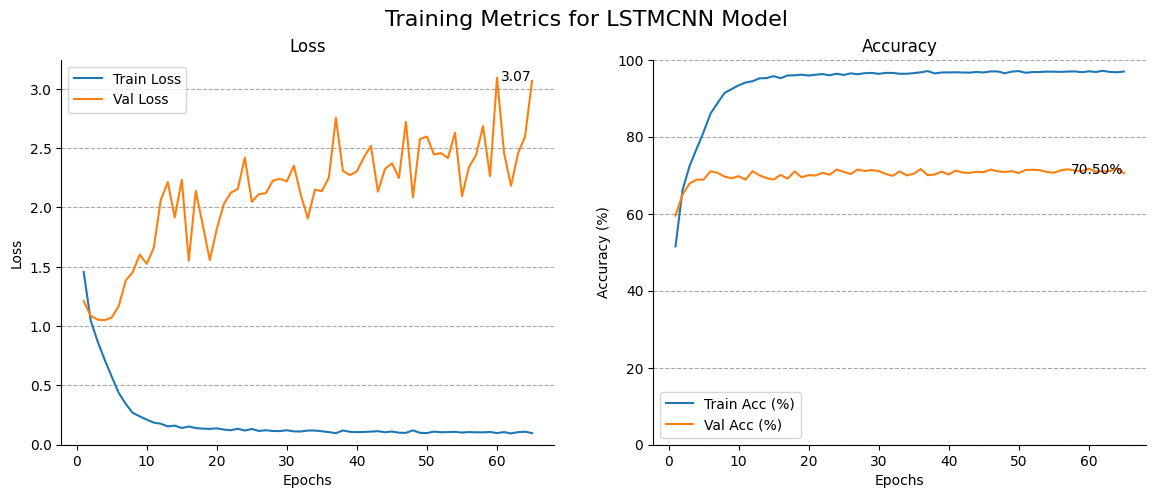


=== Evaluation Results ===
Accuracy: 0.7050, Precision: 0.7114, Recall: 0.7050, F1 Score: 0.7002
              precision    recall  f1-score   support

           0       0.54      0.48      0.51       151
           1       0.64      0.66      0.65       202
           2       0.69      0.68      0.68       195
           3       0.70      0.54      0.61       183
           4       0.77      0.64      0.70       205
           5       0.79      0.84      0.82       215
           6       0.75      0.79      0.77       193
           7       0.54      0.75      0.63       196
           8       0.75      0.67      0.71       168
           9       0.95      0.82      0.88       211
          10       0.88      0.86      0.87       198
          11       0.67      0.82      0.73       201
          12       0.60      0.66      0.63       202
          13       0.88      0.83      0.85       194
          14       0.75      0.77      0.76       189
          15       0.58      0.89    

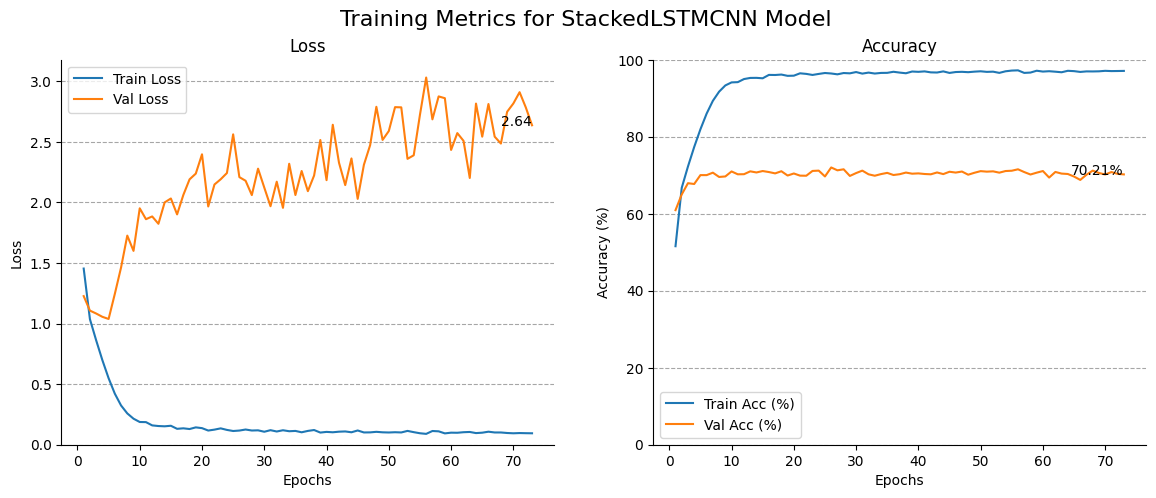


=== Evaluation Results ===
Accuracy: 0.7021, Precision: 0.7133, Recall: 0.7021, F1 Score: 0.7041
              precision    recall  f1-score   support

           0       0.58      0.50      0.54       151
           1       0.71      0.64      0.68       202
           2       0.65      0.67      0.66       195
           3       0.52      0.70      0.60       183
           4       0.74      0.66      0.70       205
           5       0.82      0.83      0.82       215
           6       0.77      0.66      0.71       193
           7       0.49      0.70      0.58       196
           8       0.69      0.72      0.70       168
           9       0.86      0.82      0.83       211
          10       0.90      0.87      0.89       198
          11       0.87      0.69      0.77       201
          12       0.65      0.64      0.64       202
          13       0.85      0.84      0.84       194
          14       0.73      0.83      0.77       189
          15       0.69      0.79    

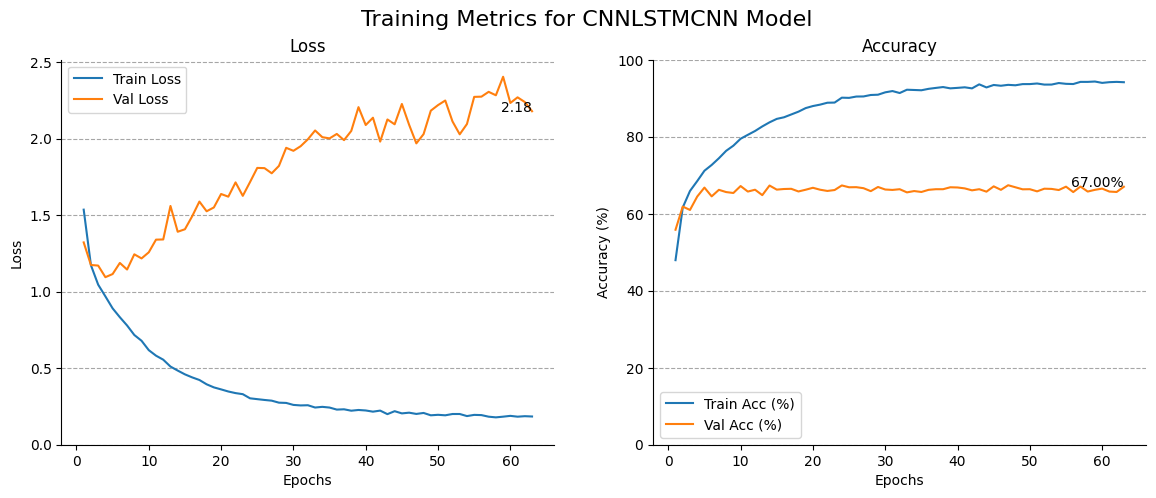


=== Evaluation Results ===
Accuracy: 0.6700, Precision: 0.6763, Recall: 0.6700, F1 Score: 0.6679
              precision    recall  f1-score   support

           0       0.50      0.48      0.49       151
           1       0.67      0.57      0.61       202
           2       0.63      0.54      0.59       195
           3       0.51      0.67      0.58       183
           4       0.65      0.68      0.66       205
           5       0.73      0.85      0.79       215
           6       0.73      0.68      0.70       193
           7       0.51      0.69      0.58       196
           8       0.71      0.64      0.67       168
           9       0.86      0.82      0.84       211
          10       0.86      0.81      0.84       198
          11       0.82      0.71      0.76       201
          12       0.74      0.53      0.62       202
          13       0.76      0.85      0.80       194
          14       0.69      0.74      0.71       189
          15       0.72      0.77    

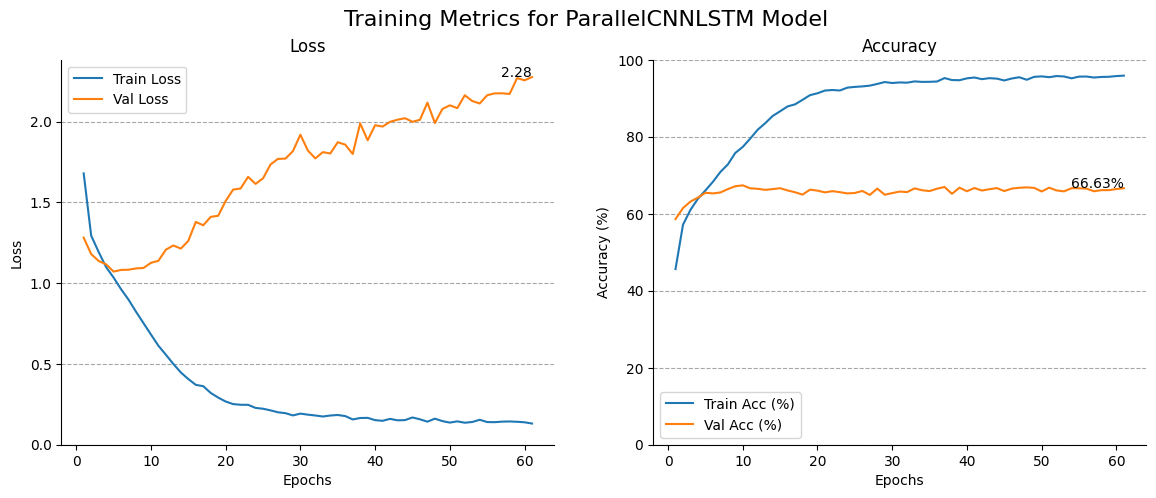


=== Evaluation Results ===
Accuracy: 0.6663, Precision: 0.6707, Recall: 0.6663, F1 Score: 0.6656
              precision    recall  f1-score   support

           0       0.47      0.40      0.43       151
           1       0.67      0.56      0.61       202
           2       0.61      0.66      0.63       195
           3       0.49      0.57      0.53       183
           4       0.71      0.57      0.63       205
           5       0.82      0.80      0.81       215
           6       0.75      0.70      0.73       193
           7       0.47      0.68      0.55       196
           8       0.59      0.67      0.63       168
           9       0.84      0.82      0.83       211
          10       0.82      0.86      0.84       198
          11       0.81      0.72      0.76       201
          12       0.65      0.58      0.61       202
          13       0.81      0.85      0.83       194
          14       0.73      0.74      0.74       189
          15       0.67      0.74    

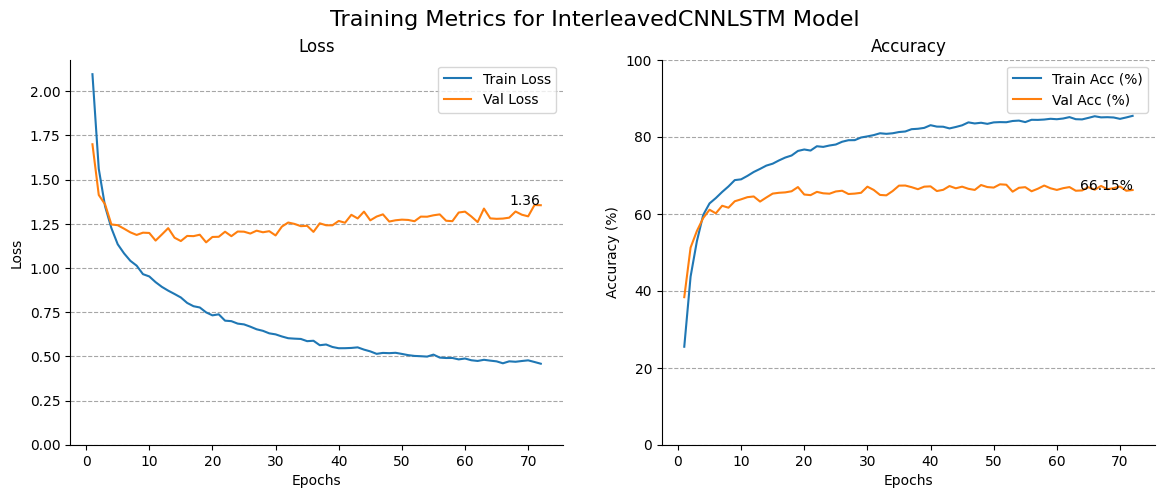


=== Evaluation Results ===
Accuracy: 0.6615, Precision: 0.6850, Recall: 0.6615, F1 Score: 0.6656
              precision    recall  f1-score   support

           0       0.34      0.68      0.46       151
           1       0.59      0.60      0.59       202
           2       0.58      0.65      0.61       195
           3       0.54      0.63      0.58       183
           4       0.74      0.62      0.68       205
           5       0.89      0.74      0.81       215
           6       0.76      0.74      0.75       193
           7       0.69      0.71      0.70       196
           8       0.69      0.65      0.67       168
           9       0.91      0.83      0.87       211
          10       0.91      0.83      0.87       198
          11       0.82      0.72      0.76       201
          12       0.71      0.58      0.64       202
          13       0.57      0.78      0.66       194
          14       0.72      0.76      0.74       189
          15       0.83      0.49    

In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import joblib
import matplotlib.pyplot as plt

def print_timer_info(message):
    print(f"[TIMER INFO] {message}")

# Set up device
def setup_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print_timer_info(f"Using device: {device}")
    torch.cuda.empty_cache()
    return device

# Load and preprocess dataset
def load_data(data_path):
    print_timer_info("Loading preprocessed dataset...")
    X_train, y_train, X_val, y_val = joblib.load(data_path)
    print_timer_info("Preprocessed dataset loaded")
    return X_train, y_train, X_val, y_val

# Convert data to tensors
def convert_to_tensors(X_train, y_train, X_val, y_val, device):
    X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(np.array(X_val), dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(np.array(y_val), dtype=torch.long).to(device)
    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor

# Dataset and DataLoader creation
class PreprocessedDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_data_loaders(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, batch_size):
    train_dataset = PreprocessedDataset(X_train_tensor, y_train_tensor)
    val_dataset = PreprocessedDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    print_timer_info("Data preparation completed")
    return train_loader, val_loader

# Model architectures
class CNNLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_lstm_layers=2, kernel_size=5, num_filters=128, dropout_prob=0.5):
        super(CNNLSTMClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout_prob)
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, num_layers=num_lstm_layers, 
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x

class LSTMCNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_lstm_layers=2, kernel_size=5, num_filters=128, dropout_prob=0.5):
        super(LSTMCNNClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_lstm_layers,
                            batch_first=True, bidirectional=True)
        self.conv1 = nn.Conv1d(in_channels=hidden_dim * 2, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(num_filters, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.mean(dim=2)
        x = self.fc(x)
        return x

class StackedLSTMCNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_lstm_layers=2, kernel_size=5, num_filters=128, dropout_prob=0.5):
        super(StackedLSTMCNNClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_lstm_layers, 
                            batch_first=True, bidirectional=True)
        self.conv1 = nn.Conv1d(in_channels=hidden_dim * 2, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(num_filters, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.mean(x, dim=2)
        x = self.fc(x)
        return x

class CNNStackedLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_lstm_layers=2, kernel_size=5, num_filters=128, dropout_prob=0.5):
        super(CNNStackedLSTMClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout_prob)
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, num_layers=num_lstm_layers, 
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

class CNNLSTMCNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_lstm_layers=1, kernel_size=5, num_filters=128, dropout_prob=0.5):
        super(CNNLSTMCNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout_prob)
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, num_layers=num_lstm_layers, 
                            batch_first=True, bidirectional=True)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim * 2, out_channels=num_filters, kernel_size=kernel_size)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.fc = nn.Linear(num_filters, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.mean(x, dim=2)
        x = self.fc(x)
        return x

class ParallelCNNLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_lstm_layers=1, kernel_size=5, num_filters=128, dropout_prob=0.5):
        super(ParallelCNNLSTMClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout_prob)
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_lstm_layers, 
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(num_filters + hidden_dim * 2, output_dim)

    def forward(self, x):
        x_cnn = x.permute(0, 2, 1)
        x_cnn = self.conv1(x_cnn)
        x_cnn = F.relu(x_cnn)
        x_cnn = self.pool(x_cnn)
        x_cnn = torch.mean(x_cnn, dim=2)
        x_lstm, _ = self.lstm(x)
        x_lstm = x_lstm[:, -1, :]
        x = torch.cat((x_cnn, x_lstm), dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class InterleavedCNNLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=5, num_filters=128, dropout_prob=0.5):
        super(InterleavedCNNLSTMClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=num_filters, kernel_size=kernel_size)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.lstm1 = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, num_layers=1, batch_first=True, bidirectional=True)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim * 2, out_channels=num_filters, kernel_size=kernel_size)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.lstm2 = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

# Training function with timing information
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, model_name):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    print_timer_info(f"Starting training for {model_name}...")
    total_start_time = time.time()  # Start timing the entire training process

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for each epoch
        model.train()
        epoch_loss, correct_predictions, total_predictions = 0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, predicted_classes = torch.max(predictions, 1)
            correct_predictions += (predicted_classes == y_batch).sum().item()
            total_predictions += y_batch.size(0)

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct_predictions / total_predictions)

        # Validation phase
        model.eval()
        val_loss, correct_predictions, total_predictions = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()
                _, predicted_classes = torch.max(predictions, 1)
                correct_predictions += (predicted_classes == y_batch).sum().item()
                total_predictions += y_batch.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_predictions / total_predictions)

        epoch_time = time.time() - epoch_start_time
        print(f"[EPOCH {epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f} - Time: {epoch_time:.2f}s")

        # Early stopping (minimum 50 epochs)
        if epoch >= 50:
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                epochs_no_improve = 0
                best_model_state = model.state_dict()
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print_timer_info(f"Early stopping triggered for {model_name} at epoch {epoch+1}")
                break

    total_time = time.time() - total_start_time  # End timing for the entire training process
    model.load_state_dict(best_model_state)
    print_timer_info(f"Training complete for {model_name} - Total Time: {total_time:.2f}s")
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name)

# Plot training and validation metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))
    plt.suptitle(f"Training Metrics for {model_name}", fontsize=16)

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', color='grey', alpha=0.7)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.ylim(bottom=0)
    plt.text(epochs[-1], val_losses[-1], f'{val_losses[-1]:.2f}', ha='right')

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [acc * 100 for acc in train_accuracies], label="Train Acc (%)")
    plt.plot(epochs, [acc * 100 for acc in val_accuracies], label="Val Acc (%)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', color='grey', alpha=0.7)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.ylim(0, 100)
    plt.text(epochs[-1], val_accuracies[-1] * 100, f'{val_accuracies[-1] * 100:.2f}%', ha='right')

    plt.show()

# Evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    all_predictions, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    print(f"\n=== Evaluation Results ===")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(all_labels, all_predictions))

# Main function
def main(model_type, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, device, input_dim=768, hidden_dim=256, output_dim=2):
    batch_size = 16
    train_loader, val_loader = create_data_loaders(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, batch_size)

    model_classes = {
        "CNNLSTM": CNNLSTMClassifier,
        "LSTMCNN": LSTMCNNClassifier,
        "StackedLSTMCNN": StackedLSTMCNNClassifier,
        "CNNStackedLSTM": CNNStackedLSTMClassifier,
        "CNNLSTMCNN": CNNLSTMCNNClassifier,
        "ParallelCNNLSTM": ParallelCNNLSTMClassifier,
        "InterleavedCNNLSTM": InterleavedCNNLSTMClassifier,
    }

    if model_type in model_classes:
        model = model_classes[model_type](input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
        model_name = f"{model_type} Model"
    else:
        raise ValueError("Invalid model type. Choose a valid model type from the list.")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 200
    patience = 10
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, model_name)
    evaluate_model(model, val_loader)

if __name__ == "__main__":
    device = setup_device()
    data_path = '/kaggle/input/sha-longs-ai6103-bert-train-test-data/bert_train_test_data.pkl'
    X_train, y_train, X_val, y_val = load_data(data_path)
    X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = convert_to_tensors(X_train, y_train, X_val, y_val, device)
    output_dim = len(np.unique(y_train))

    model_types = ["CNNLSTM", "LSTMCNN", "StackedLSTMCNN", "CNNStackedLSTM", "CNNLSTMCNN", "ParallelCNNLSTM", "InterleavedCNNLSTM"]
    for model_type in model_types:
        print(f"\nTesting {model_type} model:")
        main(model_type, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, device, input_dim=768, hidden_dim=256, output_dim=output_dim)
